Epoch [1/20], Loss: 0.6719
Epoch [2/20], Loss: 0.6221
Epoch [3/20], Loss: 0.6427
Epoch [4/20], Loss: 0.5125
Epoch [5/20], Loss: 0.5784
Epoch [6/20], Loss: 0.4476
Epoch [7/20], Loss: 0.3751
Epoch [8/20], Loss: 0.3368
Epoch [9/20], Loss: 0.3102
Epoch [10/20], Loss: 0.2035
Epoch [11/20], Loss: 0.2136
Epoch [12/20], Loss: 0.2353
Epoch [13/20], Loss: 0.2963
Epoch [14/20], Loss: 0.1195
Epoch [15/20], Loss: 0.1121
Epoch [16/20], Loss: 0.1302
Epoch [17/20], Loss: 0.1954
Epoch [18/20], Loss: 0.0857
Epoch [19/20], Loss: 0.1482
Epoch [20/20], Loss: 0.1011
Neural Network Accuracy: 0.975
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        45
         1.0       1.00      0.96      0.98        75

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120

Confusion Matrix:
[[45  0]
 [ 3 72]]


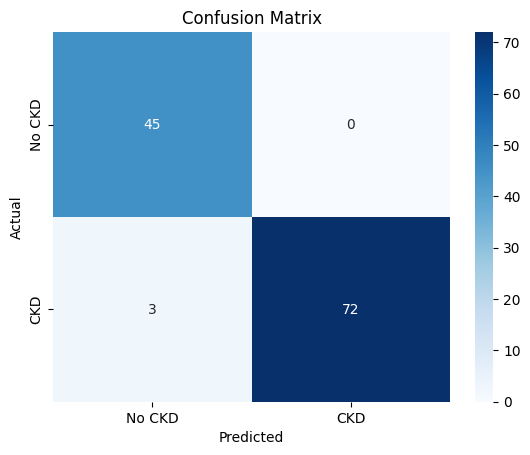

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('kidney_disease.csv')
data[['pcv', 'wc', 'rc']] = data[['pcv', 'wc', 'rc']].apply(pd.to_numeric, errors='coerce')
data_cleaned = data
numeric_columns = ['age', 'bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
data_cleaned[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
non_numeric_columns = ['sg', 'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane'] 
for column in non_numeric_columns:
    data_cleaned[column] = data[column].fillna(data[column].mode()[0])

data.replace('ckd\t', 'ckd', inplace = True)
data = data.drop(['id'], axis = 1)

X = data.drop(columns=['classification'])  # Features
y = data['classification'] 

y = y.map({'ckd': 1, 'notckd': 0})

categorical_cols = ['sg', 'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']

numerical_cols = ['age', 'bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']

numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Neural Network
class KidneyDiseasePredictor(nn.Module):
    def __init__(self, input_size):
        super(KidneyDiseasePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)  # Batch normalization
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

# Initialize the model
input_size = X_train.shape[1]
model = KidneyDiseasePredictor(input_size)

# Define loss function and optimizer
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval() 
y_pred = []  

with torch.no_grad():  
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)
        # Apply threshold to get predictions (for binary classification)
        predicted = (outputs > 0.5).float()
        # Append true and predicted labels to lists
        y_pred.extend(predicted.tolist())  # Convert tensor to list and extend y_pred

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()